# Groen, groener, groenst
Voor iedere buurt in Breda [EVI](https://en.wikipedia.org/wiki/Enhanced_vegetation_index)-data ophalen vanuit Earth Engine (blijkbaar iets heftiger dan NDVI), periode 2010 tot 2020, [MODIS](https://developers.google.com/earth-engine/datasets/catalog/MODIS_006_MOD13Q1), 250x250 meter.

In [17]:
import ee
from ipygee import *
import geopandas as gpd
import numpy as np
import datetime
import pandas as pd

In [21]:
def get_evi(start_date, end_date):
    '''to get ndvi data for breda, given start_date & end_date, returns image collection from start to end, filetered by aoi, only ndvi-band'''
    # init the ee object
    ee.Initialize()

    # define the area of interest
    breda = gpd.read_file('data/shape/breda.shp')
    breda = breda.to_crs(epsg=4326) # to lat-lon
    breda = breda.loc[0, 'geometry'].__geo_interface__
    AOI = ee.Geometry.Polygon(breda['coordinates'])

    # start - end date
    start_date = ee.Date(start_date)
    end_date = ee.Date(end_date)

    # return image collection
    return ee.ImageCollection('MODIS/006/MOD13Q1').filterDate(start_date, end_date).filterBounds(AOI).select('EVI')   

In [22]:
def to_dataframe(row):
    '''make dataframe containing mean ndvi for buurt, given row from geodataframe'''
    geometry = row['geometry'].__geo_interface__['coordinates'] # get coordinate list
    evibuurt = evi.getRegion(ee.Geometry.Polygon(geometry), 100).getInfo() # get points in geometry
    header = evibuurt[0]
    data = np.array(evibuurt[1:])

    time = [datetime.datetime.fromtimestamp(int(i)/1000) for i in data[0:,header.index('time')]] # convert timestamps
    values = data[0:,header.index('EVI')] # evi-values
    return pd.DataFrame(values, index=time, columns=[row['BU_NAAM']]).astype(float).resample('d').mean()

In [23]:
# load breda buurten
buurten = gpd.read_file('data/shape/breda_buurten.shp')
buurten = buurten.to_crs(epsg=4326) # to lat-lon

# get average EVI for each buurt in one dataframe cols -> buurt
data = pd.DataFrame()
for year in range(2010,2020): # split up in one year at a time, to not overload api
    print('{}-{} => 2020'.format(year, year + 1))
    # get ndvi for given period
    evi = get_evi(start_date='{}-01-01'.format(year), end_date='{}-01-01'.format(year + 1))

    cols = pd.DataFrame()
    for i, row in buurten.iterrows():
        df = to_dataframe(row)
        cols = pd.concat([cols, df], axis=1)
        print('{} / {}'.format(i+1, len(buurten)), end="\r")
    data = pd.concat([data, cols], axis=0)

2010-2011 => 2020
2011-2012 => 2020
2012-2013 => 2020


KeyboardInterrupt: 

In [24]:
data.groupby(data.index.year).describe()

Valkenberg                                                    \
          count         mean         std         min          25%   
2010       23.0  1499.279040  667.358580 -102.119403  1160.888060   
2011       23.0  1628.894873  542.997073  748.970149  1075.537313   

                                            ChassÃ©               ...  \
              50%          75%          max   count         mean  ...   
2010  1468.850746  2032.537313  2390.582090    23.0  1439.440393  ...   
2011  1773.686567  2098.358209  2358.134328    23.0  1654.285414  ...   

      Vuchtpolder              Buitengebied Teteringen               \
              75%          max                   count         mean   
2010  5328.397505  6370.021692                    23.0  3394.735729   
2011  5572.552603  6319.231020                    23.0  3748.483596   

                                                                       \
              std          min          25%          50%          75%   
2010  1221.245397   864.318538  2836.433420  3461.477807  4363.847258   
2011   880.791704  1624.835509  2961.856397  4043.206266  4404.577023   

                   
              max  
2010  4819.723343  
2011  5045.968668  

[2 rows x 448 columns]

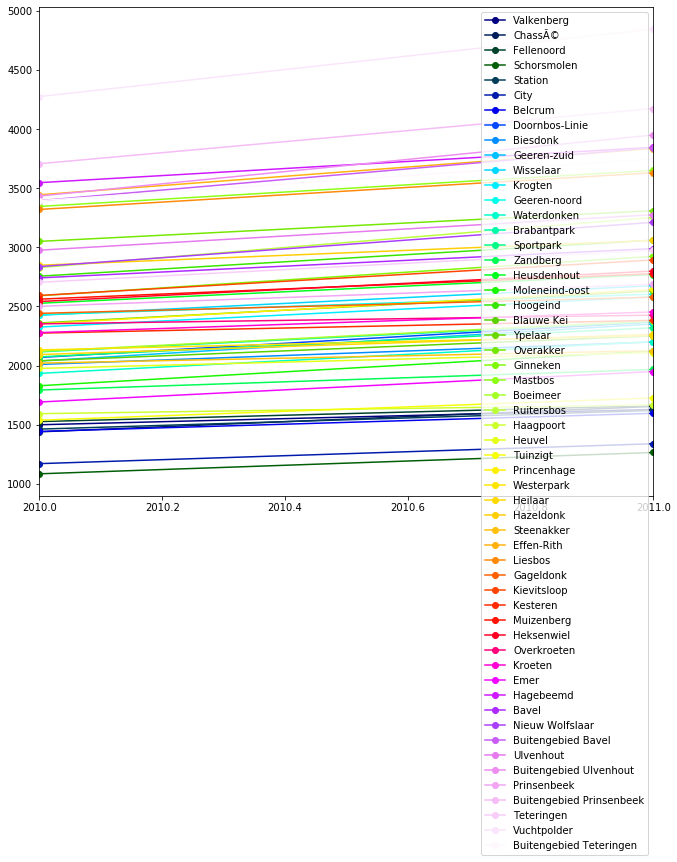

In [25]:
data.groupby(data.index.year).mean().plot(figsize=(11,9), style='-o', cmap='gist_ncar')

2010         AxesSubplot(0.1,0.15;0.363636x0.75)
2011    AxesSubplot(0.536364,0.15;0.363636x0.75)
dtype: object

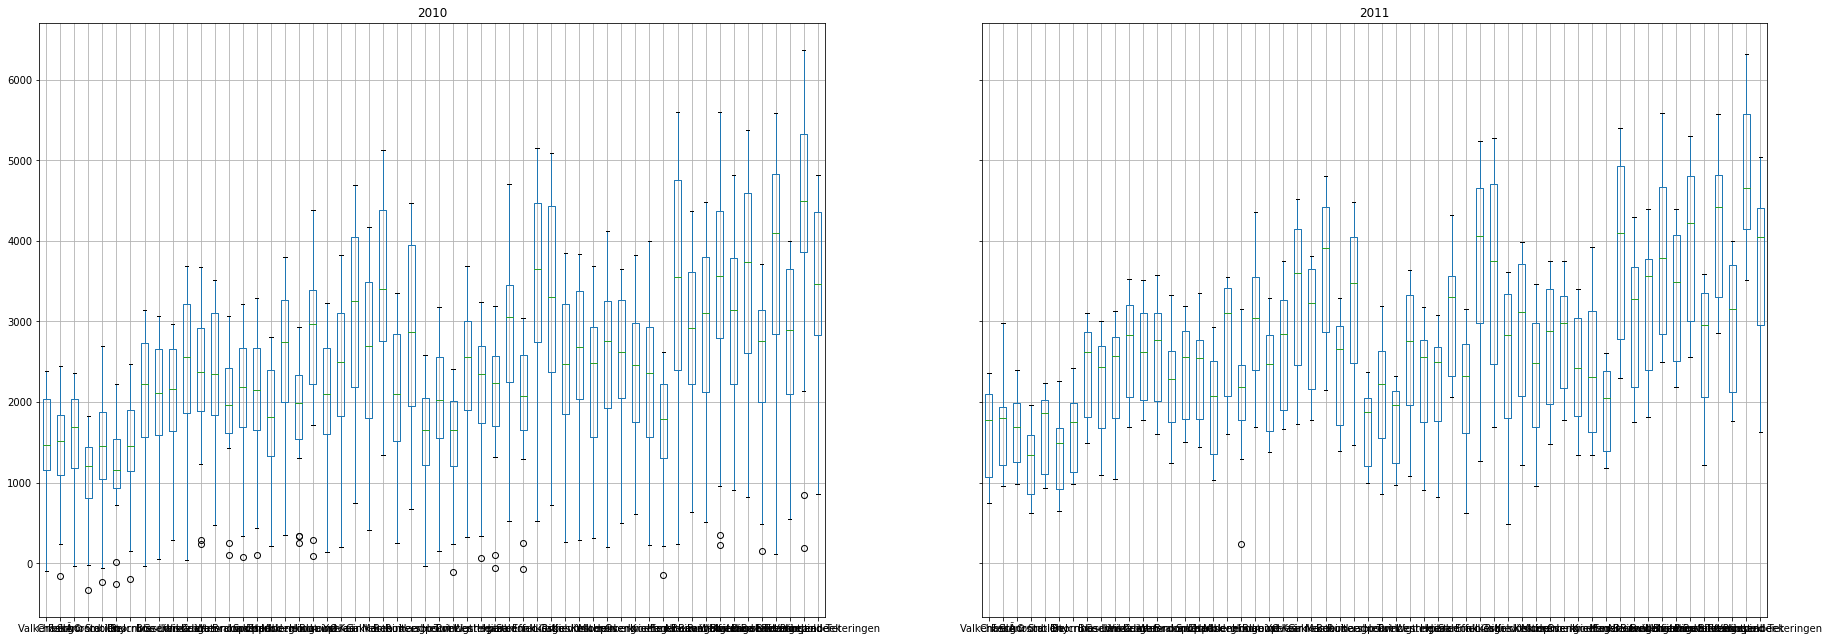

In [26]:
data.groupby(data.index.year).boxplot(figsize=(30,11))

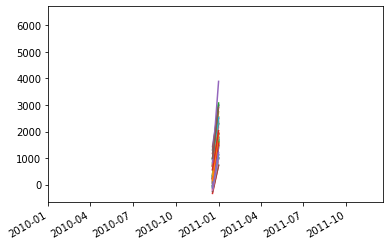

In [27]:
data.plot(legend=False)